##Deep Learning Assignment 1##

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import seaborn as sns
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
!pip install statsmodels
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [3]:
from scipy.io import loadmat
raw = loadmat('Xtrain.mat')['Xtrain']  # shape is (N,1) or (1,N)

series = raw.flatten()  # now shape is (N,)
split = int(len(series)*0.8)
train_ser, val_ser = series[:split], series[split:]


In [4]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler((0,1))
train_scaled = scaler.fit_transform(train_ser.reshape(-1,1)).flatten()
val_scaled   = scaler.transform(val_ser.reshape(-1,1)).flatten()


#EDA


Length: 1000
Min: 2.000, Max: 255.000
Mean: 59.894, Std: 46.852


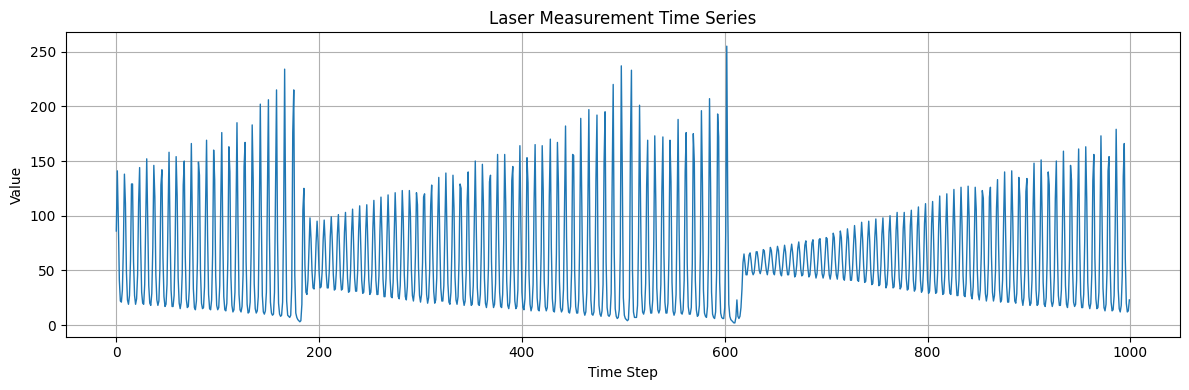

<Figure size 800x400 with 0 Axes>

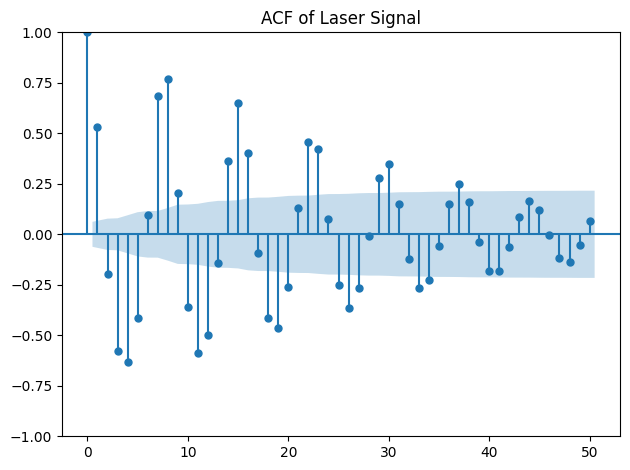

In [5]:

print(f"Length: {len(series)}")
print(f"Min: {series.min():.3f}, Max: {series.max():.3f}")
print(f"Mean: {series.mean():.3f}, Std: {series.std():.3f}")

# 3. Plot full time series
plt.figure(figsize=(12,4))
plt.plot(series, linewidth=1)
plt.title('Laser Measurement Time Series')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.grid(True)
plt.tight_layout()
plt.show()

# 4. Autocorrelation

from statsmodels.graphics.tsaplots import plot_acf


plt.figure(figsize=(8,4))
plot_acf(series, lags=50, title='ACF of Laser Signal')
plt.tight_layout()
plt.show()


#Data Preprocessing

In [6]:
split_idx   = int(0.8 * len(series))
train_series = series[:split_idx]
val_series   = series[split_idx:]


Train scaled min/max: 0.0 1.0
Val   scaled min/max: 0.03952569169960474 0.6996047430830039
X_train shape: (780, 20), y_train shape: (780,)
X_val   shape: (180, 20),   y_val   shape: (180,)


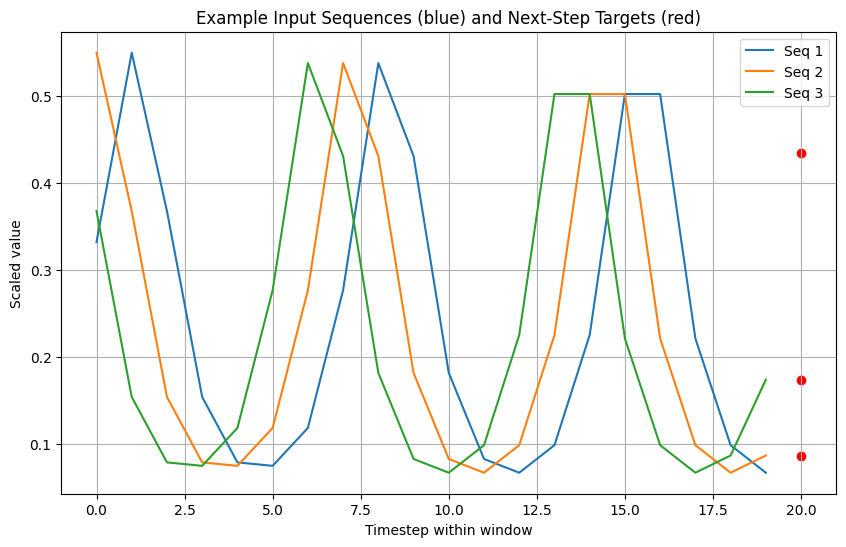

In [7]:
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit on train, transform both
train_scaled = scaler.fit_transform(train_series.reshape(-1,1)).flatten()
val_scaled   = scaler.transform(val_series.reshape(-1,1)).flatten()

print("Train scaled min/max:", train_scaled.min(), train_scaled.max())
print("Val   scaled min/max:",   val_scaled.min(),   val_scaled.max())

# --- 3. Sequence builder ---
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i : i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

window_size = 20  # you’ll tune this later

X_train, y_train = create_sequences(train_scaled, window_size)
X_val,   y_val   = create_sequences(val_scaled,   window_size)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val   shape: {X_val.shape},   y_val   shape: {y_val.shape}")

# --- 4. Visualize a few sequences + targets ---
plt.figure(figsize=(10, 6))
for i in range(min(3, len(X_train))):
    plt.plot(range(window_size), X_train[i],          label=f'Seq {i+1}')
    plt.scatter(window_size, y_train[i], color='red')  # target at t = window_size
plt.title('Example Input Sequences (blue) and Next-Step Targets (red)')
plt.xlabel('Timestep within window')
plt.ylabel('Scaled value')
plt.legend()
plt.grid(True)
plt.show()

Model Selection & Motivation:
1. Using an LSTM (Long Short-Term Memory) network for this time series prediction task.
2. Justification: 
   - LSTMs can capture long-range temporal dependencies in the laser measurement data
   - They effectively mitigate vanishing-gradient issues common in sequential data
   - Laser measurements likely contain complex temporal patterns that LSTMs are well-suited to learn
   - LSTMs have proven effective for similar time series forecasting tasks


In [8]:
# 4.1 LSTM Model Architecture
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, dropout_rate=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # x shape: (batch_size, seq_len, input_size)
        lstm_out, _ = self.lstm(x)
        # lstm_out shape: (batch_size, seq_len, hidden_size)

        # Get the output from the last time step
        lstm_out = lstm_out[:, -1, :]
        # Apply dropout
        out = self.dropout(lstm_out)
        # Linear layer for prediction
        out = self.fc(out)
        return out

# Create the model
def create_lstm_model(hidden_size=50, dropout_rate=0.2):
    model = LSTMModel(input_size=1, hidden_size=hidden_size, dropout_rate=dropout_rate)
    return model

# Create the model
model = create_lstm_model()
print(model)


# 4.3 Training Setup
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Early stopping implementation
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False
        self.best_model = None

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.best_model = model.state_dict().copy()
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                if self.best_model is not None:
                    model.load_state_dict(self.best_model)
                return True
        return False

early_stopping = EarlyStopping(patience=10)

# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train.reshape(X_train.shape[0], X_train.shape[1], 1))
y_train_tensor = torch.FloatTensor(y_train)
X_val_tensor = torch.FloatTensor(X_val.reshape(X_val.shape[0], X_val.shape[1], 1))
y_val_tensor = torch.FloatTensor(y_val)


LSTMModel(
  (lstm): LSTM(1, 50, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)


In [9]:
# 3.2 Create sequences (input-output pairs)
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        # Input sequence (X): time steps [i to i+window_size-1]
        X.append(data[i:i+window_size])
        # Target value (y): time step [i+window_size]
        y.append(data[i+window_size])
    return np.array(X), np.array(y)


In [13]:
# 4.4 Training Loop with Different Window Sizes
window_sizes = [5, 10, 20, 50 , 100]  # Different window sizes to try
num_epochs = 100
batch_size   = 64
results = {}



=== Window size: 5 ===
Epoch 10/100 → train 0.0147, val 0.0042
Epoch 20/100 → train 0.0129, val 0.0042
Epoch 30/100 → train 0.0114, val 0.0038
Epoch 40/100 → train 0.0103, val 0.0028
Epoch 50/100 → train 0.0091, val 0.0035
Epoch 60/100 → train 0.0081, val 0.0025
Epoch 70/100 → train 0.0072, val 0.0020
Epoch 80/100 → train 0.0062, val 0.0014
Epoch 90/100 → train 0.0052, val 0.0011
Epoch 100/100 → train 0.0041, val 0.0008

=== Window size: 10 ===
Epoch 10/100 → train 0.0320, val 0.0278
Epoch 20/100 → train 0.0101, val 0.0043
Epoch 30/100 → train 0.0079, val 0.0023
Epoch 40/100 → train 0.0065, val 0.0017
Epoch 50/100 → train 0.0046, val 0.0005
Epoch 60/100 → train 0.0050, val 0.0003
Epoch 70/100 → train 0.0043, val 0.0003
Epoch 80/100 → train 0.0035, val 0.0002
Epoch 90/100 → train 0.0030, val 0.0002
Epoch 100/100 → train 0.0032, val 0.0005

=== Window size: 20 ===
Epoch 10/100 → train 0.0131, val 0.0074
Epoch 20/100 → train 0.0095, val 0.0044
Epoch 30/100 → train 0.0063, val 0.0021
Epoc

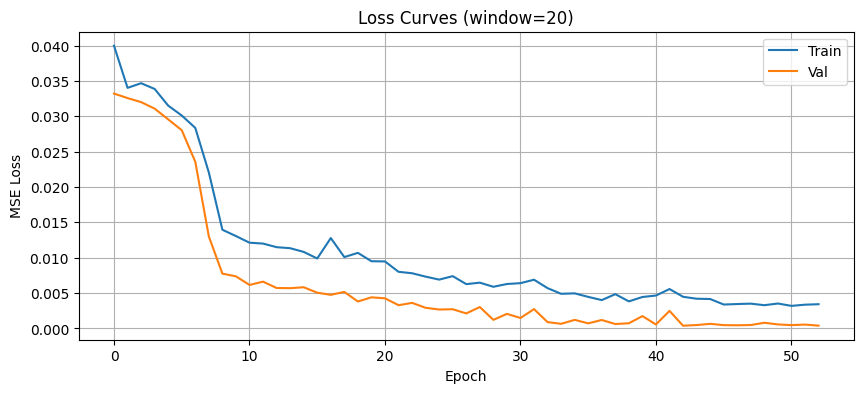

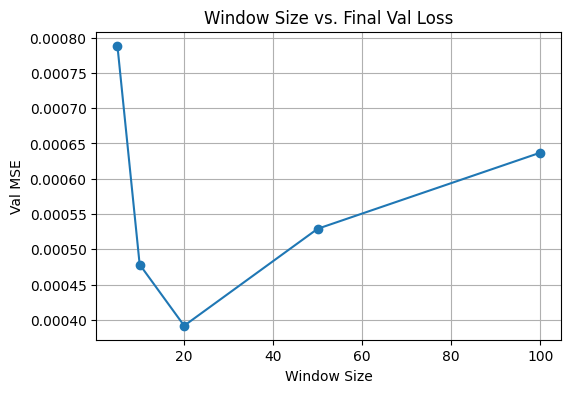

In [14]:
for ws in window_sizes:
    print(f"\n=== Window size: {ws} ===")
    # create sequences
    X_tr, y_tr = create_sequences(train_scaled, ws)
    X_va, y_va = create_sequences(val_scaled,   ws)
    # to tensors
    Xt = torch.tensor(X_tr[...,None], dtype=torch.float32)
    yt = torch.tensor(y_tr[:,None],   dtype=torch.float32)
    Xv = torch.tensor(X_va[...,None], dtype=torch.float32)
    yv = torch.tensor(y_va[:,None],   dtype=torch.float32)
    train_loader = DataLoader(TensorDataset(Xt, yt), batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(TensorDataset(Xv, yv), batch_size=batch_size)
    # model, optimizer, early stopping
    model = LSTMModel().to(device)
    opt   = optim.Adam(model.parameters(), lr=1e-3)
    es    = EarlyStopping(patience=10)
    train_losses, val_losses = [], []
    # training loop
    for epoch in range(1, num_epochs+1):
        model.train()
        epoch_train = []
        for Xb, yb in train_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            opt.zero_grad()
            loss = nn.MSELoss()(model(Xb), yb)
            loss.backward(); opt.step()
            epoch_train.append(loss.item())
        model.eval()
        epoch_val = []
        with torch.no_grad():
            for Xb, yb in val_loader:
                Xb, yb = Xb.to(device), yb.to(device)
                epoch_val.append(nn.MSELoss()(model(Xb), yb).item())
        train_losses.append(np.mean(epoch_train))
        val_losses.append(np.mean(epoch_val))
        if epoch % 10 == 0:
            print(f"Epoch {epoch}/{num_epochs} → train {train_losses[-1]:.4f}, val {val_losses[-1]:.4f}")
        if es(val_losses[-1], model):
            print(f"Early stopping at epoch {epoch}")
            break

    results[ws] = {
        'model':        model,              # ← save the model itself
        'train_losses': train_losses,
        'val_losses':   val_losses,
        'final_val_loss':    val_losses[-1]
    }


# 8. Select best window size
best_ws = min(results, key=lambda w: results[w]['final_val_loss'])
print(f"\nBest window size = {best_ws}, val loss = {results[best_ws]['final_val_loss']:.4f}")

# 9. Plot losses for best model
plt.figure(figsize=(10,4))
plt.plot(results[best_ws]['train_losses'], label='Train')
plt.plot(results[best_ws]['val_losses'],   label='Val')
plt.title(f"Loss Curves (window={best_ws})")
plt.xlabel('Epoch'); plt.ylabel('MSE Loss')
plt.legend(); plt.grid(); plt.show()

# 10. Plot val loss vs window size
plt.figure(figsize=(6,4))
ws_list = list(results.keys())
vlosses = [results[w]['final_val_loss'] for w in ws_list]
plt.plot(ws_list, vlosses, marker='o')
plt.title('Window Size vs. Final Val Loss')
plt.xlabel('Window Size'); plt.ylabel('Val MSE'); plt.grid(); plt.show()

##Using the trained model for 200 window

 Best window size = 20


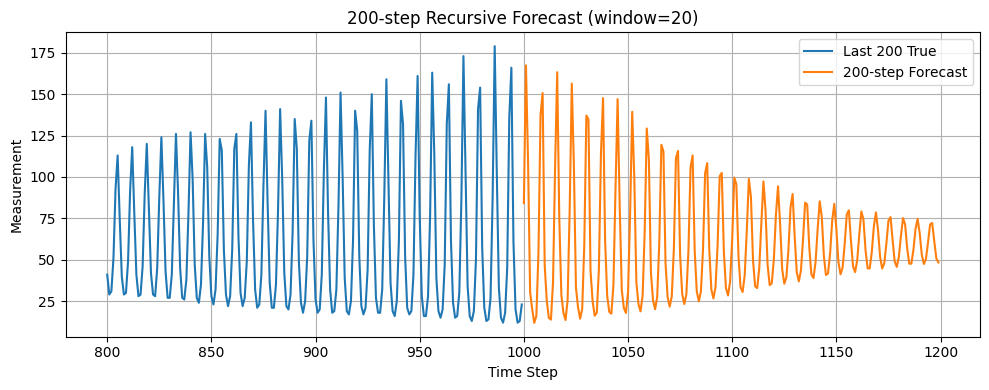

In [15]:
best_ws = min(results.keys(), key=lambda w: results[w]['final_val_loss'])
print(f" Best window size = {best_ws}")

# Retrieve the corresponding trained model
best_model = results[best_ws]['model']
best_model.eval()

# (c) Recursive 200-step forecast
# — Scale the full series
full_scaled = scaler.transform(series.reshape(-1,1)).flatten()

# — Seed with the last best_ws true points
buf = list(full_scaled[-best_ws:])
preds_scaled = []

for _ in range(200):
    x = torch.tensor(buf[-best_ws:], dtype=torch.float32)[None,:,None].to(device)
    with torch.no_grad():
        p = best_model(x).item()
    preds_scaled.append(p)
    buf.append(p)

# — Inverse-scale
preds = scaler.inverse_transform(np.array(preds_scaled)[:,None]).flatten()

#plotting
plt.figure(figsize=(10,4))
#last 200 true points
plt.plot(np.arange(len(series)-200, len(series)), series[-200:], label='Last 200 True')
#Visualize the forecast
plt.plot(np.arange(len(series), len(series)+200), preds, label='200-step Forecast')
plt.xlabel('Time Step')
plt.ylabel('Measurement')
plt.title(f'200-step Recursive Forecast (window={best_ws})')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Deeper LSTM**

In [34]:
# 4.1 LSTM Model Architecture with Multiple Layers
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import TimeSeriesSplit

# Define the multi-layer LSTM model
class DeepLSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=3, dropout_rate=0.2):
        super(DeepLSTMModel, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout_rate if num_layers > 1 else 0
        )
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(hidden_size, hidden_size // 2)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size // 2, 1)

    def forward(self, x):
        # x shape: (batch_size, seq_len, input_size)
        lstm_out, _ = self.lstm(x)
        # lstm_out shape: (batch_size, seq_len, hidden_size)

        # Get the output from the last time step
        lstm_out = lstm_out[:, -1, :]
        # Apply dropout
        out = self.dropout(lstm_out)
        # Add fully connected layers for better feature extraction
        out = self.fc1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out

# Create the model
def create_deep_lstm_model(hidden_size=64, num_layers=3, dropout_rate=0.5):
    model = DeepLSTMModel(
        input_size=1,
        hidden_size=hidden_size,
        num_layers=num_layers,
        dropout_rate=dropout_rate
    )
    return model

# Create the model with multiple layers
deep_model = create_deep_lstm_model()
print(deep_model)


# 4.3 Training Setup
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(deep_model.parameters(), lr=0.001, weight_decay=1e-5)

# Time Series Cross-Validation
tscv = TimeSeriesSplit(n_splits=5, test_size=None, gap=0)

# Early stopping implementation
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False
        self.best_model = None

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.best_model = model.state_dict().copy()
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                if self.best_model is not None:
                    model.load_state_dict(self.best_model)
                return True
        return False

early_stopping = EarlyStopping(patience=15)

# Example of using TimeSeriesSplit for model evaluation
def time_series_cv_evaluation(X, y, model, criterion, optimizer, n_splits=5, epochs=50):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    cv_scores = []

    for train_idx, test_idx in tscv.split(X):
        # Split data
        X_train_fold, X_test_fold = X[train_idx], X[test_idx]
        y_train_fold, y_test_fold = y[train_idx], y[test_idx]

        # Convert to tensors - ensure proper reshaping
        X_train_tensor = torch.FloatTensor(X_train_fold).unsqueeze(-1)  # Add channel dimension safely
        y_train_tensor = torch.FloatTensor(y_train_fold)
        X_test_tensor = torch.FloatTensor(X_test_fold).unsqueeze(-1)  # Add channel dimension safely
        y_test_tensor = torch.FloatTensor(y_test_fold)

        # Create data loaders
        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=32)

        # Reset model
        model.apply(lambda m: m.reset_parameters() if hasattr(m, 'reset_parameters') else None)
        optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

        # Train model
        for epoch in range(epochs):
            model.train()
            for X_batch, y_batch in train_loader:
                optimizer.zero_grad()
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()

        # Evaluate model
        model.eval()
        test_losses = []
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                outputs = model(X_batch)
                test_loss = criterion(outputs, y_batch).item()
                test_losses.append(test_loss)

        cv_scores.append(np.mean(test_losses))

    return cv_scores


DeepLSTMModel(
  (lstm): LSTM(1, 64, num_layers=3, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=32, out_features=1, bias=True)
)



=== Window size: 5 ===
Epoch 10/100 → train 0.0534, val 0.0310
Epoch 20/100 → train 0.0562, val 0.0293
Epoch 30/100 → train 0.0484, val 0.0254
Epoch 40/100 → train 0.0125, val 0.0308
Epoch 50/100 → train 0.0167, val 0.0195
Early stopping at epoch 50
Epoch 10/100 → train 0.0179, val 0.0051
Epoch 20/100 → train 0.0153, val 0.0044
Epoch 30/100 → train 0.0124, val 0.0034
Epoch 40/100 → train 0.0130, val 0.0025
Epoch 50/100 → train 0.0147, val 0.0026
Epoch 60/100 → train 0.0124, val 0.0021
Epoch 70/100 → train 0.0137, val 0.0022
Epoch 80/100 → train 0.0150, val 0.0024
Early stopping at epoch 83
Epoch 10/100 → train 0.0111, val 0.0135
Early stopping at epoch 18
Epoch 10/100 → train 0.0133, val 0.0242
Epoch 20/100 → train 0.0131, val 0.0229
Epoch 30/100 → train 0.0127, val 0.0235
Epoch 40/100 → train 0.0115, val 0.0227
Epoch 50/100 → train 0.0121, val 0.0228
Epoch 60/100 → train 0.0118, val 0.0205
Epoch 70/100 → train 0.0105, val 0.0179
Epoch 80/100 → train 0.0110, val 0.0126
Epoch 90/100 → 

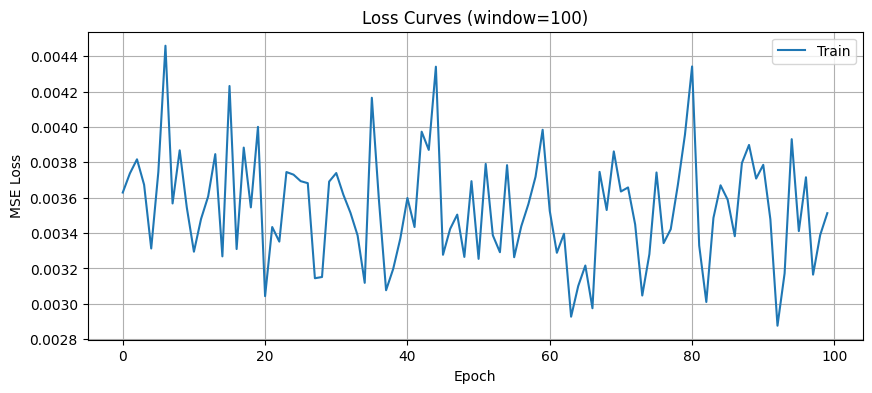

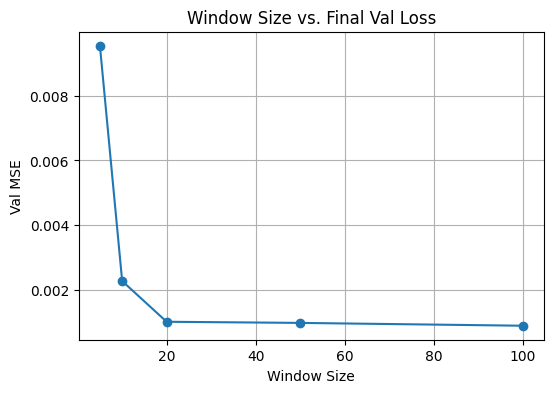

In [35]:
# Use TimeSeriesSplit for proper time series validation
tscv = TimeSeriesSplit(n_splits=5)

for ws in window_sizes:
    print(f"\n=== Window size: {ws} ===")
    # create sequences
    X, y = create_sequences(train_scaled, ws)

    # Initialize lists to store cross-validation results
    cv_train_losses = []
    cv_val_losses = []

    for train_idx, val_idx in tscv.split(X):
        # Split data using time series cross-validation
        X_tr, X_va = X[train_idx], X[val_idx]
        y_tr, y_va = y[train_idx], y[val_idx]

        # to tensors
        Xt = torch.tensor(X_tr[...,None], dtype=torch.float32)
        yt = torch.tensor(y_tr[:,None], dtype=torch.float32)
        Xv = torch.tensor(X_va[...,None], dtype=torch.float32)
        yv = torch.tensor(y_va[:,None], dtype=torch.float32)

        train_loader = DataLoader(TensorDataset(Xt, yt), batch_size=batch_size, shuffle=False)
        val_loader = DataLoader(TensorDataset(Xv, yv), batch_size=batch_size)

        # model, optimizer, early stopping
        model = deep_model.to(device)  # Using the deep_model defined earlier
        optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # Match optimizer from setup
        early_stopping = EarlyStopping(patience=15)  # Match early stopping from setup
        train_losses, val_losses = [], []

        # training loop
        for epoch in range(1, num_epochs+1):
            model.train()
            epoch_train = []
            for Xb, yb in train_loader:
                Xb, yb = Xb.to(device), yb.to(device)
                optimizer.zero_grad()
                loss = criterion(model(Xb), yb)  # Using the criterion defined earlier
                loss.backward()
                optimizer.step()
                epoch_train.append(loss.item())

            model.eval()
            epoch_val = []
            with torch.no_grad():
                for Xb, yb in val_loader:
                    Xb, yb = Xb.to(device), yb.to(device)
                    epoch_val.append(criterion(model(Xb), yb).item())

            train_losses.append(np.mean(epoch_train))
            val_losses.append(np.mean(epoch_val))

            if epoch % 10 == 0:
                print(f"Epoch {epoch}/{num_epochs} → train {train_losses[-1]:.4f}, val {val_losses[-1]:.4f}")

            if early_stopping(val_losses[-1], model):
                print(f"Early stopping at epoch {epoch}")
                break

        cv_train_losses.append(train_losses[-1])
        cv_val_losses.append(val_losses[-1])

    # Average the results across all folds
    avg_train_loss = np.mean(cv_train_losses)
    avg_val_loss = np.mean(cv_val_losses)

    # Train final model on all training data
    X_tr, y_tr = create_sequences(train_scaled, ws)
    Xt = torch.tensor(X_tr[...,None], dtype=torch.float32)
    yt = torch.tensor(y_tr[:,None], dtype=torch.float32)
    train_loader = DataLoader(TensorDataset(Xt, yt), batch_size=batch_size, shuffle=True)

    # Final model training
    final_model = deep_model.to(device)
    optimizer = optim.Adam(final_model.parameters(), lr=0.001, weight_decay=1e-5)
    train_losses = []

    for epoch in range(1, num_epochs+1):
        final_model.train()
        epoch_train = []
        for Xb, yb in train_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            optimizer.zero_grad()
            loss = criterion(final_model(Xb), yb)
            loss.backward()
            optimizer.step()
            epoch_train.append(loss.item())

        train_losses.append(np.mean(epoch_train))
        if epoch % 10 == 0:
            print(f"Final model - Epoch {epoch}/{num_epochs} → train {train_losses[-1]:.4f}")

    results[ws] = {
        'model': final_model,        # ← save the final model
        'train_losses': train_losses,
        'cv_val_loss': avg_val_loss,
        'final_val_loss': avg_val_loss
    }

    print(f"Window size {ws}: Avg CV val loss = {avg_val_loss:.4f}")

# 8. Select best window size
best_ws = min(results, key=lambda w: results[w]['final_val_loss'])
print(f"\nBest window size = {best_ws}, val loss = {results[best_ws]['final_val_loss']:.4f}")

# 9. Plot losses for best model
plt.figure(figsize=(10,4))
plt.plot(results[best_ws]['train_losses'], label='Train')
plt.title(f"Loss Curves (window={best_ws})")
plt.xlabel('Epoch'); plt.ylabel('MSE Loss')
plt.legend(); plt.grid(); plt.show()

# 10. Plot val loss vs window size
plt.figure(figsize=(6,4))
ws_list = list(results.keys())
vlosses = [results[w]['final_val_loss'] for w in ws_list]
plt.plot(ws_list, vlosses, marker='o')
plt.title('Window Size vs. Final Val Loss')
plt.xlabel('Window Size'); plt.ylabel('Val MSE'); plt.grid(); plt.show()

 Best window size = 100


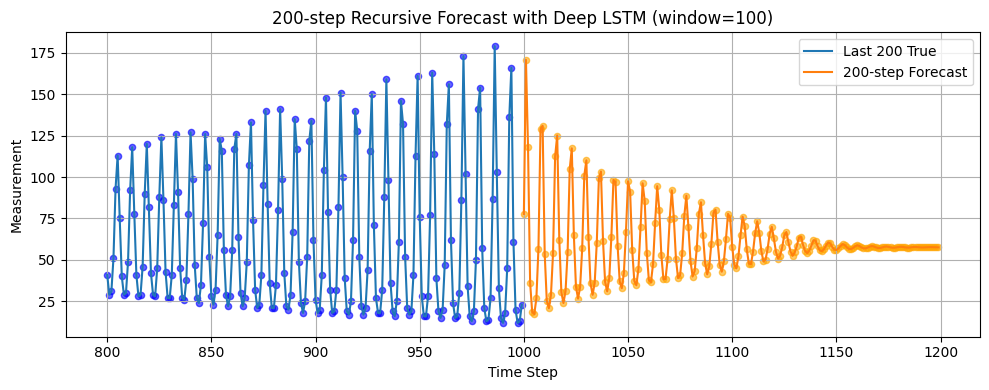

In [37]:
best_ws = min(results.keys(), key=lambda w: results[w]['final_val_loss'])
print(f" Best window size = {best_ws}")

# Retrieve the corresponding trained model
best_model = results[best_ws]['model']
best_model.eval()

# (c) Recursive 200-step forecast
# — Scale the full series
full_scaled = scaler.transform(series.reshape(-1,1)).flatten()

# — Seed with the last best_ws true points
buf = list(full_scaled[-best_ws:])
preds_scaled = []
# For Deep LSTM, we need to reshape input properly
for _ in range(200):
    # Reshape for LSTM: [batch_size, sequence_length, features]
    x = torch.tensor(buf[-best_ws:], dtype=torch.float32).unsqueeze(0).unsqueeze(-1).to(device)
    with torch.no_grad():
        # Get prediction from model
        p = best_model(x).item()
    preds_scaled.append(p)
    buf.append(p)

# — Inverse-scale
preds = scaler.inverse_transform(np.array(preds_scaled)[:,None]).flatten()

#plotting
plt.figure(figsize=(10,4))
#last 200 true points
plt.plot(np.arange(len(series)-200, len(series)), series[-200:], label='Last 200 True')
plt.scatter(np.arange(len(series)-200, len(series)), series[-200:], color='blue', s=20, alpha=0.6)

#Visualize the forecast
plt.plot(np.arange(len(series), len(series)+200), preds, label='200-step Forecast')
plt.scatter(np.arange(len(series), len(series)+200), preds, color='orange', s=20, alpha=0.6)

plt.xlabel('Time Step')
plt.ylabel('Measurement')
plt.title(f'200-step Recursive Forecast with Deep LSTM (window={best_ws})')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**New try with drop feature**

In [24]:
# Load data from the previously defined series
data = series.squeeze().astype(int)

# --- Drop detection ---
diff = np.diff(data, prepend=data[0])  # same length as data
is_drop = (diff < -40).astype(int)

# --- Combine features: value + drop indicator ---
features = np.column_stack((data, is_drop))

# --- Normalize 'value' column only ---
scaler = MinMaxScaler()
features[:, 0:1] = scaler.fit_transform(features[:, 0:1])  # keep is_drop unchanged

# --- Create sequences ---
def create_sequences_with_features(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i : i + window_size])
        y.append(data[i + window_size][0])  # predict next value
    return np.array(X), np.array(y)

window_size = 20
X, y = create_sequences_with_features(features, window_size)

# --- Train/test split ---
split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# --- Define LSTM model properly ---
class LSTMModel(nn.Module):
    def __init__(self, input_size=2, hidden_size=64, output_size=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        # Take only the last time step output
        lstm_out = lstm_out[:, -1, :]
        # Apply dropout to the output of the LSTM
        out = self.dropout(lstm_out)
        # Pass through the fully connected layer
        out = self.fc(out)
        return out

# Initialize model and optimizer
model = LSTMModel().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1).to(device)

# Training loop
num_epochs = 100
best_val_loss = float('inf')
patience = 10
patience_counter = 0

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test_tensor)
        val_loss = criterion(val_outputs, y_test_tensor)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict().copy()
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch}")
        break

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

# Load best model
model.load_state_dict(best_model_state)

Epoch 0, Loss: 0.0028, Val Loss: 0.0006
Epoch 10, Loss: 0.0014, Val Loss: 0.0000
Epoch 20, Loss: 0.0014, Val Loss: 0.0000
Epoch 30, Loss: 0.0014, Val Loss: 0.0000
Early stopping at epoch 31


<All keys matched successfully>

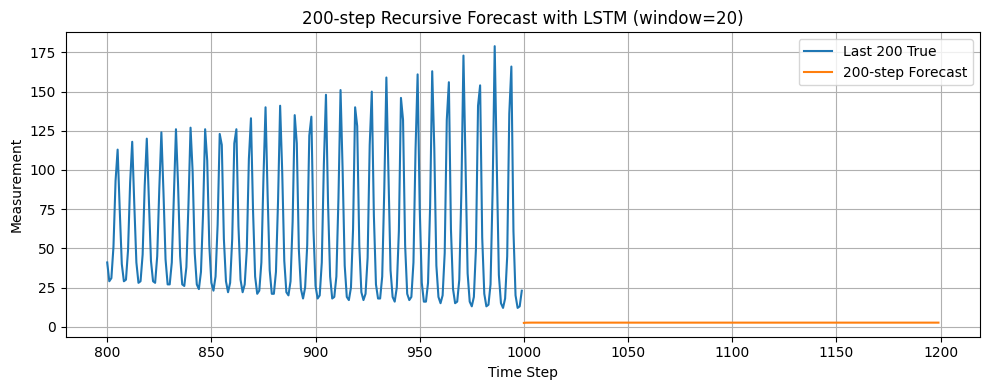

In [26]:
# Use the trained model from above instead of from results dictionary
best_model = model  # Use the model we just trained
best_model.eval()

# Get the window size from our training data
best_ws = X_train.shape[1]  # Window size is the sequence length used in training

# (c) Recursive 200-step forecast
# — Scale the full series
full_scaled = scaler.transform(series.reshape(-1,1)).flatten()

# — Seed with the last best_ws true points
buf = list(full_scaled[-best_ws:])
preds_scaled = []

# For Deep LSTM, we need to reshape input properly
for _ in range(200):
    # Reshape for LSTM: [batch_size, sequence_length, features]
    x = torch.tensor(buf[-best_ws:], dtype=torch.float32).unsqueeze(0).to(device)
    # Add feature dimension for LSTM input [batch_size, sequence_length, features]
    x = x.unsqueeze(2)  # Add feature dimension
    with torch.no_grad():
        # Get prediction from model
        p = best_model(x).item()
    preds_scaled.append(p)
    buf.append(p)

# — Inverse-scale
preds = scaler.inverse_transform(np.array(preds_scaled)[:,None]).flatten()

#plotting
plt.figure(figsize=(10,4))
#last 200 true points
plt.plot(np.arange(len(series)-200, len(series)), series[-200:], label='Last 200 True')
#Visualize the forecast
plt.plot(np.arange(len(series), len(series)+200), preds, label='200-step Forecast')
plt.xlabel('Time Step')
plt.ylabel('Measurement')
plt.title(f'200-step Recursive Forecast with LSTM (window={best_ws})')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()